In [ ]:
# pip install pyro-ppl

In [1]:
import os
import torch
from torch.distributions import constraints
from torch import tensor

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

assert pyro.__version__.startswith('1.8')
pyro.set_rng_seed(1)
torch.manual_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]

In [4]:
from sklearn.datasets import load_iris

X_df, y = load_iris(as_frame=True, return_X_y=True)

In [5]:
target_names = ['setosa', 'versicolor', 'virginica']

In [6]:
# standardize X
X_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = X_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

X['iris_type'] = y
X['is_setosa'] = np.where(X['iris_type'].values == 0, 1,0)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   iris_type     150 non-null    int32  
 5   is_setosa     150 non-null    int32  
dtypes: float64(4), int32(2)
memory usage: 6.0 KB


In [7]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_type,is_setosa
0,-0.897674,1.015602,-1.335752,-1.311052,0,1
1,-1.139200,-0.131539,-1.335752,-1.311052,0,1
2,-1.380727,0.327318,-1.392399,-1.311052,0,1
3,-1.501490,0.097889,-1.279104,-1.311052,0,1
4,-1.018437,1.245030,-1.335752,-1.311052,0,1


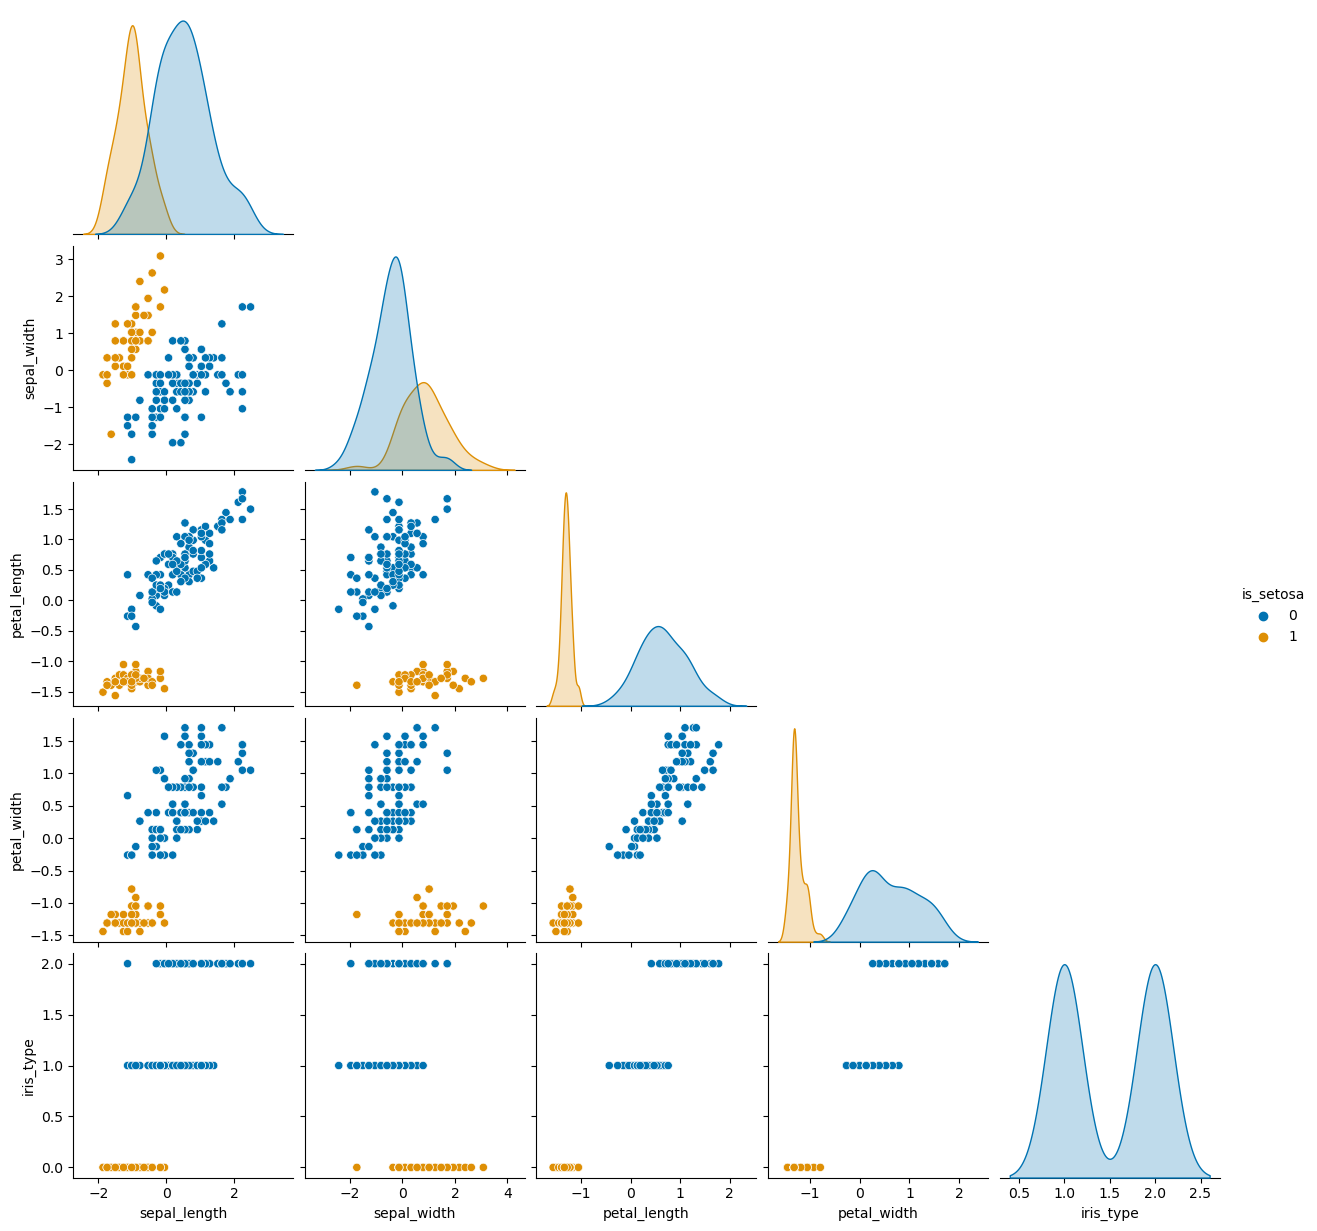

In [10]:
#setosa is completely separable.versicolor and virginica are harder to distinguish
sns.pairplot(data=X, hue='is_setosa', palette="colorblind", corner=True); 

## Make a logistic regression model of 
is_setosa ~ 'petal_width'

### Using sklearn

In [11]:
X['petal_width'].shape, X['is_setosa'].shape

((150,), (150,))

In [12]:
from sklearn.linear_model import LogisticRegression
#C = 1e9 means no L2 regularization
clf = LogisticRegression(C=1e9, random_state=0).fit(X['petal_width'].values.reshape(-1,1), X['is_setosa'])

# these are the parameters we expect to recover (will find out separability plays an issue in the coefficients, though!
print(clf.coef_)
print(clf.intercept_)

[[-38.69692782]]
[-21.54793048]


In [13]:
# convert to tensors
data = tensor(X[['petal_width']].values, dtype=torch.float)
target = tensor(X['is_setosa'].values, dtype=torch.float)

In [ ]:
data.size(), target.size()

## Logistic Regression Using Pyro

### We'll use more of the power of pytorch by making a class based on torch.nn.Linear and the Pyro classes PyroSample and PyroModule 

In [15]:
#### Note: I chose the prior for the coefficients based on the results from sklearn above purely for convenience

In [14]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-35., 5.).expand([out_features, in_features]).to_event(2)) #PRIOR
        if bias:
            self.linear.bias = PyroSample(dist.Uniform(-25., 5.).expand([out_features]).to_event(1)) #PRIOR
        
    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1) #matrix multiplication of the unknown coefficients * X. Model will learn coeffs during training

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y) #likelihood
        return logits

In [20]:
### recall that in logistic regression we are modeling the logits (= log odds) and then solving for probability of y=1. 
### This is just a Bernoulli distribution likelihood! dist.Bernoulli can take either the logits or probabilities as input.

### re: expand() and to_event() functions: see (non-intuitive) docs at https://pyro.ai/examples/tensor_shapes.html. for now, you should just accept it.

In [21]:
data.size(0), data.size(1)

(150, 1)

In [25]:
model = BayesianLogisticRegression(in_features=data.size(1)) #one vector of length 150 as input (petal_width) 

In [29]:
from pyro.infer.autoguide import AutoMultivariateNormal # basic autoguide for quick SVI performance

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [22]:
def train(model, guide, lr=0.01, n_steps=2000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")

In [30]:
%%time
train(model, guide, n_steps=1400)

Elbo loss: 9.350290536880493
Elbo loss: 3.2292504608631134
Elbo loss: 1.9547613619361073
CPU times: total: 1min 16s
Wall time: 12.9 s


In [31]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data, target).items()
               if k != "obs"}

In [32]:
svi_samples.keys()

dict_keys(['linear.weight', 'linear.bias'])

In [33]:
svi_samples['linear.bias'].mean()

-15.578904

In [34]:
svi_samples['linear.weight'].mean(axis=0)

array([-34.461], dtype=float32)

In [40]:
guide.quantiles([0.5]) #median value for the intercept and the slope term

{'linear.weight': tensor([[[-34.4411]]]), 'linear.bias': tensor([[-15.7299]])}

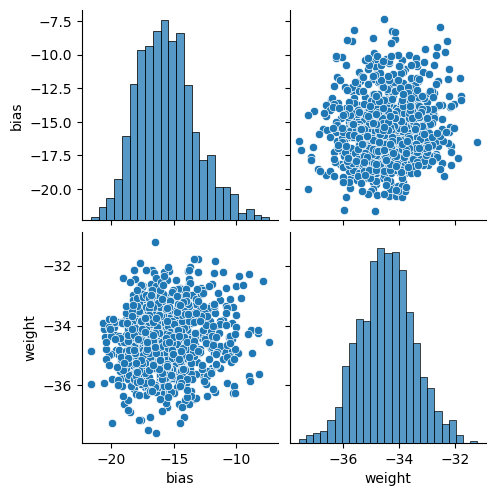

In [38]:
samples = pd.DataFrame({'bias':svi_samples['linear.bias'].squeeze(), 'weight':svi_samples['linear.weight'].squeeze()})
sns.pairplot(data=samples);

In [41]:
# compare with sklearn answer
print(clf.intercept_)
print(clf.coef_)

[-21.54793048]
[[-38.69692782]]


# What about MCMC?

In [42]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)

In [43]:
%%time
mcmc.run(data, target)

Sample: 100%|████████████████████████████████████████| 1500/1500 [00:53, 28.21it/s, step size=3.73e-01, acc. prob=0.808]                    

CPU times: total: 5min 13s
Wall time: 53.2 s


In [44]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [45]:
hmc_samples.keys()

dict_keys(['linear.bias', 'linear.weight'])

In [46]:
np.median(hmc_samples['linear.bias'])

-18.108912

In [47]:
np.median(hmc_samples['linear.weight'])

-35.102154

In [50]:
# Can see that the median for the MCMC solution is "closer" to the sklearn solution. 
# Between SVI and MCMC, MCMC will always give the more exact solution (assuming the model is well-specified!) 
print(clf.intercept_)
print(clf.coef_)


[-21.54793048]
[[-38.69692782]]


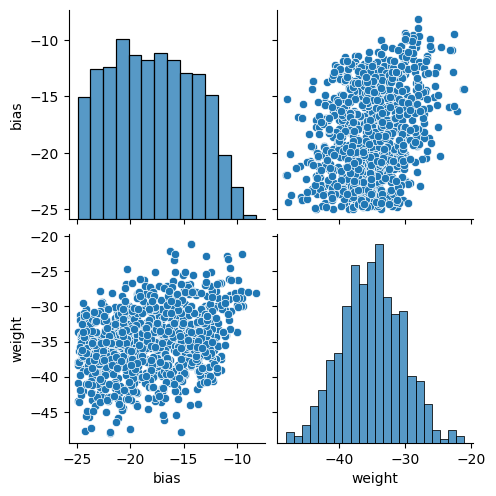

In [48]:
samples = pd.DataFrame({'bias':hmc_samples['linear.bias'].squeeze(), 'weight':hmc_samples['linear.weight'].squeeze()})
sns.pairplot(data=samples);

## Let's try predicting the iris_type as a multinomial logit, so model will output 0,1, or 2 for target_names = ['setosa', 'versicolor', 'virginica']
## '(iris_type) ~ sepal_length + sepal_width + petal_length + petal_width'
### note: due to perfect separation of some of the data, particularly setosa, the multinomial logit fails to converge!

In [51]:
import statsmodels.formula.api as smf

In [53]:
mod = smf.mnlogit(formula='iris_type ~ sepal_length + sepal_width + petal_length + petal_width', data=X)

In [54]:
result = mod.fit()
print(result.summary()) #Maximum number of iterations has been exceeded.
# Notice it has a wide range of values for all model coefficients

         Current function value: 0.039662
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:              iris_type   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Mon, 04 Apr 2022   Pseudo R-squ.:                  0.9639
Time:                        14:41:01   Log-Likelihood:                -5.9493
converged:                      False   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 7.055e-64
 iris_type=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       28.6123   4.64e+05   6.17e-05      1.000   -9.09e+05    9.09e+05
sepal_length    -6.5351    1.4e+06  -4.65e-06      1.000   

C:\Users\seanr\Miniconda3\envs\pyro\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

class BayesianMultinomialLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-10., 5.).expand([out_features, in_features]).to_event(2)) #prior
        if bias:
            self.linear.bias = PyroSample(dist.Normal(-1., 2.).expand([out_features]).to_event(1)) #prior
        
    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y) # For n>2, use Categorical instead of Bernoulli
        return logits

In [58]:
model_2 = BayesianMultinomialLogisticRegression(in_features=4)

In [59]:
guide_2 = AutoMultivariateNormal(model_2, init_loc_fn=init_to_mean)

In [60]:
def train(model, guide, lr=0.1, n_steps=4000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")


In [61]:
data = tensor(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values, dtype=torch.float)
target = tensor(X['iris_type'].values, dtype=torch.float)

data.size(), target.size()

(torch.Size([150, 4]), torch.Size([150]))

In [62]:
%%time
train(model_2, guide_2)

Elbo loss: 3802.357560634613
Elbo loss: 550.3787572383881
Elbo loss: 550.4911649227142
Elbo loss: 550.7274096012115
Elbo loss: 550.708053946495
Elbo loss: 550.9701700210571
Elbo loss: 550.9140706062317
Elbo loss: 550.7344167232513
CPU times: total: 2min 10s
Wall time: 21.8 s


In [63]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model_2)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=500)
mcmc.run(data, target)

Sample: 100%|████████████████████████████████████████| 2500/2500 [00:56, 43.97it/s, step size=4.95e-01, acc. prob=0.918]                    


In [64]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [65]:
hmc_samples.keys()

dict_keys(['linear.bias', 'linear.weight'])

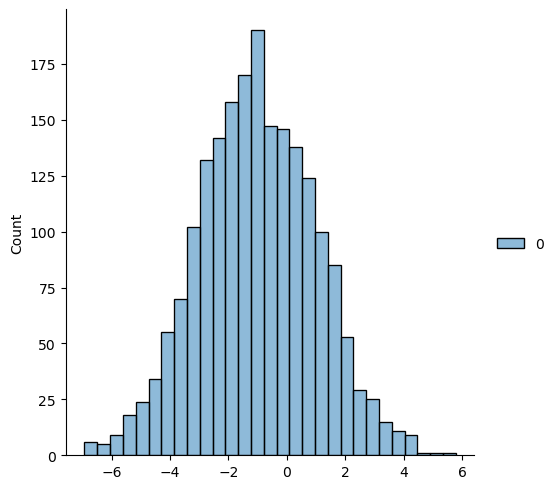

In [68]:
sns.displot(data=hmc_samples['linear.bias']);

In [72]:
hmc_samples['linear.weight'].shape

(2000, 1, 4)

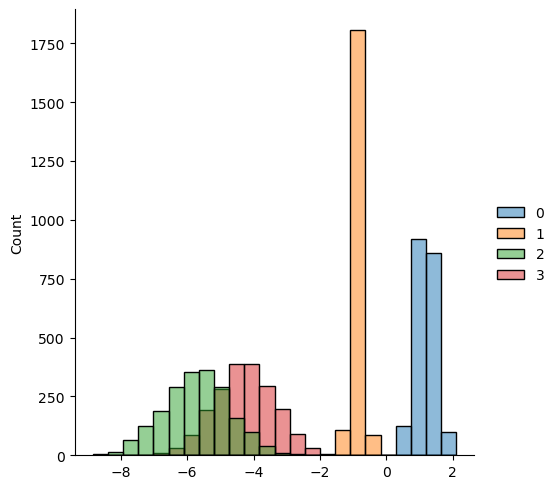

In [75]:
sns.displot(data=np.squeeze(hmc_samples['linear.weight']));